# **Regresión Dinámica Directa para doble péndulo**

In [1]:
import math
import numpy as np
import tensorflow as tf
import keras 
#from tensorflow import keras
from keras.models import Sequential #One of the most important classes in tensorflow, used to creare NN (Named after NN as a sequence of layers)
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, InputLayer #Dense layer means that one neuron in one layer is connected to all neurons in the next layer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.utils import shuffle
import pandas as pd
import matplotlib.pyplot as plt
#from keras_tuner import RandomSearch

2024-12-29 14:22:52.725732: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


No supported GPU was found.


In [2]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [3]:
model_name = "dp_backDyn_FF"     # val_loss=0.0016, 80 épocas, 50 mil muestras random
model_name = "dp_backDyn_FF_1"   # val_loss=0.0009, 171 épocas, 50 mil muestras random
fileNameScalers = f'/content/drive/My Drive/Colab Notebooks/{model_name}_scalers.pkl'
fileNameModel = f'/content/drive/My Drive/Colab Notebooks/{model_name}_.h5'

In [4]:
datos_2LRP_random = pd.read_csv(f'./2lpr_randomsamples_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_joint = pd.read_csv(f'./2lpr_jointmovement_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_cart = pd.read_csv(f'./2lpr_cartesianmovement_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
datos_2LRP_torq = pd.read_csv(f'./2lpr_forcedtorques_sinusoidal_2024-10-03.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

In [5]:
pos_j1 = datos_2LRP_random.iloc[:,1].values
pos_j2 = datos_2LRP_random.iloc[:,2].values

vels_j1 = datos_2LRP_random.iloc[:,3].values
vels_j2 = datos_2LRP_random.iloc[:,4].values

accs_j1 = datos_2LRP_random.iloc[:,5].values
accs_j2 = datos_2LRP_random.iloc[:,6].values

torq_j1 = datos_2LRP_random.iloc[:,7].values
torq_j2 = datos_2LRP_random.iloc[:,8].values

In [6]:
time_joint = datos_2LRP_joint.iloc[:,1].values

pos_j1_joint = datos_2LRP_joint.iloc[:,2].values
pos_j2_joint = datos_2LRP_joint.iloc[:,3].values

vels_j1_joint = datos_2LRP_joint.iloc[:,4].values
vels_j2_joint = datos_2LRP_joint.iloc[:,5].values

accs_j1_joint = datos_2LRP_joint.iloc[:,6].values
accs_j2_joint = datos_2LRP_joint.iloc[:,7].values

torq_j1_joint = datos_2LRP_joint.iloc[:,8].values
torq_j2_joint = datos_2LRP_joint.iloc[:,9].values

In [7]:
time_cart = datos_2LRP_cart.iloc[:,1].values

pos_j1_cart = datos_2LRP_cart.iloc[:,2].values
pos_j2_cart = datos_2LRP_cart.iloc[:,3].values

vels_j1_cart = datos_2LRP_cart.iloc[:,4].values
vels_j2_cart = datos_2LRP_cart.iloc[:,5].values

accs_j1_cart = datos_2LRP_cart.iloc[:,6].values
accs_j2_cart = datos_2LRP_cart.iloc[:,7].values

torq_j1_cart = datos_2LRP_cart.iloc[:,8].values
torq_j2_cart = datos_2LRP_cart.iloc[:,9].values

In [8]:
time_torq = datos_2LRP_torq.iloc[:,1].values

pos_j1_torq = datos_2LRP_torq.iloc[:,2].values
pos_j2_torq = datos_2LRP_torq.iloc[:,3].values

vels_j1_torq = datos_2LRP_torq.iloc[:,4].values
vels_j2_torq = datos_2LRP_torq.iloc[:,5].values

accs_j1_torq = datos_2LRP_torq.iloc[:,6].values
accs_j2_torq = datos_2LRP_torq.iloc[:,7].values

torq_j1_torq = datos_2LRP_torq.iloc[:,8].values
torq_j2_torq = datos_2LRP_torq.iloc[:,9].values

In [9]:
time_torq.shape


(1000,)

# **Red neuronal Secuencial (Same-step approach)**:

No es el entrenamiento de las redes lo que se compara, sino la calidad de los resultados finales. Cada red tiene una técnica de entrenamiento: las secuenciales no aprenden la correlación entre muestras, entonces es mejor entrenarlas con muestras descorrelacionadas -> ruido blanco, en cambio, las redes LSTM aprenden la historia y evolución del sistema (la correlación entre muestras), van a necesitar muestras ordenadas, secuencia de tiempo.

Problema Dinámico INVERSO: Dados las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición.

En el método de same step approach, tengo que tener en cuenta cómo se describe la fórmula a analizar. Para el problema inverso, tengo en cuenta que la expresión de la dinámica es una función contínua, pero todo refiere al mismo instante de tiempo, ya que dadas las posiciones, velocidades y aceleraciones, el valor de torque obtenido es aquel para mantener esta posición. Entonces los valores de posición y velocidad son para el instante de tiempo del torque resultante. 

Para el caso de la posición, no tiene sentido el same step approach, porque quiero calcular la posición siguiente

# **Red neuronal Secuencial (One-step-ahead approach)**

¿Es válido hacer un análisis One Step Ahead si el problema dinámico inverso se plantea como dadas las posiciones, velocidades y aceleraciones joint, obtener el valor de los torques necesarios para mantener esa posición?

Para el análisis con los datos randomizados, no tengo una secuencialidad de los datos ya que cada muestra es randomizada. Voy a probarlo con otro conjunto de muestras, pero inicialmente, creería que para resolver el problema dinámico no tiene sentido utilizar este método.

In [10]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time = datos_2LRP_joint.iloc[1:-1,1].values

pos_j1 = datos_2LRP_joint.iloc[:-2,2].values
pos_j2 = datos_2LRP_joint.iloc[:-2,3].values

vels_j1 = datos_2LRP_joint.iloc[:-2,4].values
vels_j2 = datos_2LRP_joint.iloc[:-2,5].values

accs_j1 = datos_2LRP_joint.iloc[1:-1,6].values
accs_j2 = datos_2LRP_joint.iloc[1:-1,7].values

torq_j1 = datos_2LRP_joint.iloc[1:-1,8].values
torq_j2 = datos_2LRP_joint.iloc[1:-1,9].values

next_pos_j1 = datos_2LRP_joint.iloc[1:-1,2].values
next_pos_j2 = datos_2LRP_joint.iloc[1:-1,3].values

In [11]:
inputs = np.vstack((pos_j1, pos_j2, vels_j1, vels_j2, torq_j1, torq_j2)).T
#outputs = np.vstack((accs_j1, accs_j2)).T
outputs = np.vstack((next_pos_j1, next_pos_j2)).T

In [12]:
X_train_OSA, X_test_OSA, y_train_OSA, y_test_OSA = train_test_split(inputs, outputs, test_size = 0.15)
X_train_OSA, X_val_OSA, y_train_OSA, y_val_OSA = train_test_split(X_train_OSA, y_train_OSA, test_size=0.15)

In [13]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_OSA = StandardScaler()
X_train_OSA = scaler1_OSA.fit_transform(X_train_OSA)#Primero se llama a la funcion fit para que ajuste los datos
X_test_OSA = scaler1_OSA.transform(X_test_OSA) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_OSA = scaler1_OSA.transform(X_val_OSA)

#Lo mismo para los outputs
scaler2_OSA = StandardScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train_OSA = scaler2_OSA.fit_transform(y_train_OSA)
y_test_OSA = scaler2_OSA.transform(y_test_OSA)
y_val_OSA = scaler2_OSA.transform(y_val_OSA)

In [14]:
#Esta forma es lo más parecida posible al paper
FFNN_OSA_network = keras.models.Sequential([
    keras.layers.Dense(units=100, activation="tanh", input_shape=(inputs.shape[1],)),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(2)
])
FFNN_OSA_network.summary()

/Users/melinagabrielacheminet/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 100)            │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,102 (82.43 KB)

 Trainable params: 21,102 (82.43 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#keras.optimizers.Adam(learning_rate=0.001)
FFNN_OSA_network.compile(loss = 'mean_squared_error', optimizer='adam', metrics = ['mae'])#Que pasa si uso SGD con learning rate

In [16]:
#checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CT_p/Modelos_NN/FF_NN_OSA_EPOCHS/ff_nn-{epoch:02d}.h5")
#Si uso Validation Set --> Puedo elegir Best Model & Hacer Early Stopping
#checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CT_p/Modelos_NN/LINEAR/ff_nn_OSA_Best_Model.h5", save_best_only=True)
checkpoint_cb = keras.callbacks.ModelCheckpoint("./DD_NN_Pos/Modelos_NN/FF_OSA/ff_nn_OSA_Best_Model.keras", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience=30, min_delta=1e-10, restore_best_weights=True)

In [17]:
FFNN_OSA_history = FFNN_OSA_network.fit(X_train_OSA, y_train_OSA, epochs=400, batch_size=100, validation_data=(X_val_OSA, y_val_OSA), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0525 - mae: 0.1197 - val_loss: 0.0012 - val_mae: 0.0264
Epoch 2/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9.4018e-04 - mae: 0.0239 - val_loss: 5.1524e-04 - val_mae: 0.0179
Epoch 3/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5363e-04 - mae: 0.0166 - val_loss: 2.9726e-04 - val_mae: 0.0132
Epoch 4/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 2.7086e-04 - mae: 0.0128 - val_loss: 3.6563e-04 - val_mae: 0.0152
Epoch 5/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.2636e-04 - mae: 0.0117 - val_loss: 1.6724e-04 - val_mae: 0.0097
Epoch 6/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1.6918e-04 - mae: 0.0102 - val_loss: 1.5053e-04 - val_mae: 0.0098
Epoch 7/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.5064e-04 - mae: 0.0096 - val_loss: 1.3080e-04 - val_mae: 0.0095
Epoch 8/400
301/301 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.2293e-04 - mae: 0.0087 - val_loss: 1.5586e-04 - val_mae:

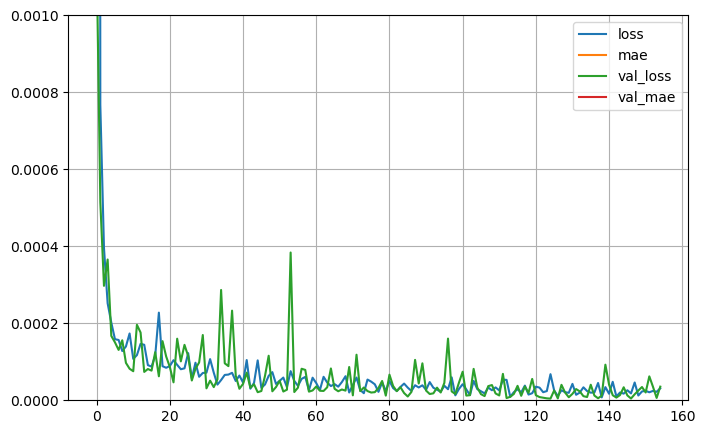

In [18]:
pd.DataFrame(FFNN_OSA_history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_ylim(0, 1)
plt.gca().set_ylim(0, 0.001)
plt.show()

In [19]:
accuracy_test_OSA = FFNN_OSA_network.evaluate(X_test_OSA, y_test_OSA)

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - loss: 4.3661e-06 - mae: 0.0016


In [20]:
predictions_OSA = FFNN_OSA_network.predict(X_test_OSA)

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [21]:
predictions_OSA[0]

array([1.3750569, 1.6297635], dtype=float32)

In [22]:
y_test_OSA[0]

array([1.3776523 , 1.63058957])

In [23]:
predictions_OSA[:,0]

array([ 1.3750569 , -0.9489749 , -1.4787549 , ...,  0.18344249,
       -0.39216164, -0.8395539 ], dtype=float32)

# **Red neuronal LSTM con Dataset JOINT**

In [24]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time = datos_2LRP_joint.iloc[1:-1,1].values

pos_j1 = datos_2LRP_joint.iloc[:-2,2].values
pos_j2 = datos_2LRP_joint.iloc[:-2,3].values

vels_j1 = datos_2LRP_joint.iloc[:-2,4].values
vels_j2 = datos_2LRP_joint.iloc[:-2,5].values

torq_j1 = datos_2LRP_joint.iloc[1:-1,8].values
torq_j2 = datos_2LRP_joint.iloc[1:-1,9].values

accs_j1 = datos_2LRP_joint.iloc[1:-1,6].values
accs_j2 = datos_2LRP_joint.iloc[1:-1,7].values

next_pos_j1 = datos_2LRP_joint.iloc[1:-1,2].values
next_pos_j2 = datos_2LRP_joint.iloc[1:-1,3].values

In [25]:
inputs = np.vstack((pos_j1, pos_j2, vels_j1, vels_j2, torq_j1, torq_j2)).T
#inputs = np.vstack((pos_j1, pos_j2, torq_j1, torq_j2)).T
outputs = np.vstack((next_pos_j1, next_pos_j2)).T

In [26]:
inputs.shape

(41616, 6)

In [27]:
def create_lstm_sequences(inputs, outputs, time_joint, window_size=50, split=0.8):
    """
    Genera secuencias de entrada y salida para una LSTM a partir de los datos de posición, velocidad, aceleración y torque.
    
    Args:
        inputs: Matriz de entrada que contiene las posiciones, velocidades y aceleraciones.
        outputs: Matriz de salida que contiene los torques.
        time_joint: Vector de tiempo asociado a los datos.
        window_size: Tamaño de la ventana de tiempo para la LSTM.
        split: Proporción del dataset que se utiliza para entrenamiento (el resto para prueba).
        
    Returns:
        X_train: Secuencias de entrada para entrenamiento.
        Y_train: Secuencias de salida para entrenamiento.
        X_test: Secuencias de entrada para prueba.
        Y_test: Secuencias de salida para prueba.
        t_test: Vector de tiempo correspondiente al conjunto de prueba.
    """
    # Preparar las secuencias de entrada y salida usando ventanas deslizantes
    input_sequences = []
    output_sequences = []
    
    for i in range(len(inputs) - window_size):
        input_sequences.append(inputs[i:i+window_size])
        output_sequences.append(outputs[i+window_size])
    
    # Convertir a arrays numpy
    X = np.array(input_sequences)
    Y = np.array(output_sequences)
    
    # Dividir en conjuntos de entrenamiento y prueba
    if split > 0 and split < 1:
        idx_split = int(split * len(X))
        X_train, X_test = X[:idx_split], X[idx_split:]
        Y_train, Y_test = Y[:idx_split], Y[idx_split:]
        t_test = time_joint[idx_split:-window_size-len(inputs)]
    else:
        X_train, X_test = X, None
        Y_train, Y_test = Y, None
        t_test = time_joint[:-window_size-len(inputs)]
    
    return X_train, Y_train, X_test, Y_test, t_test


In [28]:
#Para las LSTM es necesario que defin
# N_segments = 50 #Puntos destino de movimiento joint

# Definir el tamaño de la ventana de tiempo para las secuencias
w_size = 6

# Aplicar StandardScaler
scaler1_LSTM = MinMaxScaler(feature_range=(0, 1)) #RobustScaler() #MinMaxScaler() #StandardScaler()
inputs = scaler1_LSTM.fit_transform(inputs)

scaler2_LSTM = MinMaxScaler(feature_range=(0, 1)) #RobustScaler() #MinMaxScaler() #StandardScaler()
outputs = scaler2_LSTM.fit_transform(outputs)

X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM, t_test_LSTM  = create_lstm_sequences(inputs, outputs, time_joint, window_size=w_size, split=0.8)


In [29]:
X_train_LSTM.shape

(33288, 6, 6)

In [30]:
LSTM_network = Sequential()

#Stateless
LSTM_network.add(LSTM(units=100, input_shape=(w_size, X_train_LSTM.shape[2]), dropout=0, activation='tanh', return_sequences=True))
LSTM_network.add(LSTM(100, activation='tanh', dropout=0, return_sequences=True))
LSTM_network.add(LSTM(100, activation='tanh', dropout=0))

LSTM_network.add(Dense(y_train_LSTM.shape[1]))

LSTM_network.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Nadam(learning_rate=1e-5), metrics = ['mae'])
LSTM_network.summary()


/Users/melinagabrielacheminet/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 100)         │        42,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 6, 100)         │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,802 (796.10 KB)

 Trainable params: 203,802 (796.10 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
#LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/CT_p/Modelos_NN/LINEAR/LSTM_nn_Best_Model.h5", save_best_only=True)
LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("./DD_N_Pos/Modelos_NN/LSTM/LSTM_nn_Best_Model.keras",save_best_only=True)
LSTM_early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=25, min_delta=1E-7, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-10, verbose=1)

In [32]:
#LSTM_history = LSTM_network.fit(X_train_LSTM, y_train_LSTM, epochs=100, validation_data=(X_val_LSTM, y_val_LSTM), callbacks=[LSTM_checkpoint_cb, LSTM_early_stopping_cb])
#LSTM_history = LSTM_network.fit(X_train_LSTM, y_train_LSTM, batch_size=10, epochs=500, callbacks=[LSTM_checkpoint_cb]), reduce_lr
LSTM_history = LSTM_network.fit(X_train_LSTM, y_train_LSTM, epochs=1000, batch_size=150, validation_split=0.3, callbacks=[LSTM_checkpoint_cb, LSTM_early_stopping_cb])

Epoch 1/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 0.3517 - mae: 0.5409 - val_loss: 0.2032 - val_mae: 0.3873
Epoch 2/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.2888 - mae: 0.4834 - val_loss: 0.1481 - val_mae: 0.3168
Epoch 3/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.2000 - mae: 0.3908 - val_loss: 0.0745 - val_mae: 0.2104
Epoch 4/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.0847 - mae: 0.2396 - val_loss: 0.0382 - val_mae: 0.1517
Epoch 5/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 0.0338 - mae: 0.1518 - val_loss: 0.0379 - val_mae: 0.1538
Epoch 6/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 53ms/step - loss: 0.0296 - mae: 0.1413 - val_loss: 0.0349 - val_mae: 0.1470
Epoch 7/1000
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 0.0261 - mae: 0.1322 - val_loss: 0.0314 - val_mae: 0.1388
Epoch 8/1000
 96/130 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0238 - mae: 0.1253

KeyboardInterrupt: 

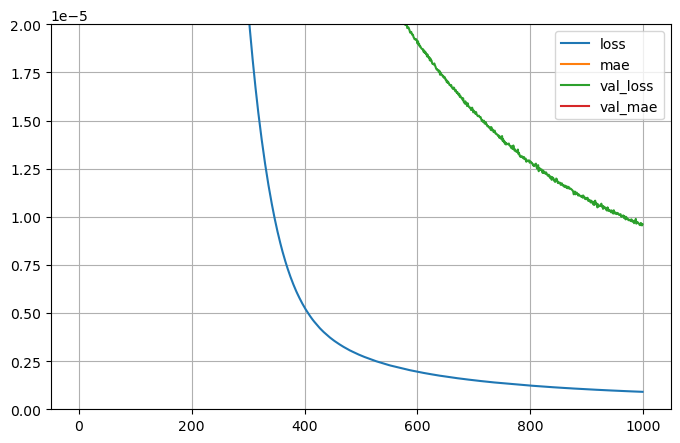

In [33]:
pd.DataFrame(LSTM_history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 0.00002)
plt.show()

In [34]:
LSTM_accuracy_test = LSTM_network.evaluate(X_test_LSTM, y_test_LSTM)

261/261 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 8.1932e-06 - mae: 0.0024


In [35]:
predictions_LSTM = LSTM_network.predict(X_test_LSTM)

261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [36]:
predictions_LSTM[0]

array([0.07940254, 0.49300042], dtype=float32)

In [37]:
y_test_LSTM[0]

array([0.07441165, 0.49764529])

# **Red neuronal LSTM con calculo directo de la posición, sin velocidades**

In [38]:
def create_sequences(t_ref, q_ref, tau_ref, window_size=50, split=0.8):
    """
    Genera las secuencias de entrada (q,tau) y salida (q) para el modelo LSTM.

    Args:
      t_ref: Vector de tiempo de referencia
      q_ref: Vector de posiciones articulares de referencia
      tau_ref: Vector de torques de referencia
      window_size: Tamaño de la ventana de tiempo que considera la red LSTM
      spĺit: proporción del dataset que se deja para pruebas

    Returns:
      X_train: Secuencias de entrada (q,tau) para entrenamiento
      Y_train: Secuencias de salida (q) para entrenamiento
      X_test: Secuencias de entrada (q,tau) para prueba
      Y_test: Secuencias de salida (q) para prueba
      t_test: Vector de tiempo de prueba
    """
    # Combinar los datos para crear secuencias
    # Las salidas van un paso adelante que las entradas de captar
    # de marcar la relación causa-efecto
    outputs = q_ref[1:-1,:]
    #input_data =  np.hstack((q_ref, qd_ref,tau_ref))
    inputs =  np.hstack((q_ref[0:-2,:], tau_ref[0:-2,:]))

    input_sequences = []
    output_sequences = []
    for i in range(len(inputs) - window_size):
        input_sequences.append(inputs[i:i+window_size])
        output_sequences.append(outputs[i+window_size])

    # En la terminología de redes LSTM, las entradas son X y las salidas Y
    X = np.array(input_sequences)
    Y = np.array(output_sequences)

    # Dividir los datos en conjuntos de entrenamiento y prueba
    if split>0 and split<1:
      idx_split = int(split * len(X))
      X_train, X_test = X[:idx_split], X[idx_split:]
      Y_train, Y_test = Y[:idx_split], Y[idx_split:]
      t_test = t_ref[idx_split:-window_size-2]
    else:
      X_train, X_test = X, None
      Y_train, Y_test = Y, None
      t_test = t_ref[0:-window_size-2]
    return X_train,Y_train,X_test,Y_test,t_test

In [39]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time = datos_2LRP_joint.iloc[:,1].values

pos_j1 = datos_2LRP_joint.iloc[:,2].values
pos_j2 = datos_2LRP_joint.iloc[:,3].values

vels_j1 = datos_2LRP_joint.iloc[:,4].values
vels_j2 = datos_2LRP_joint.iloc[:,5].values

torq_j1 = datos_2LRP_joint.iloc[:,8].values
torq_j2 = datos_2LRP_joint.iloc[:,9].values

accs_j1 = datos_2LRP_joint.iloc[:,6].values
accs_j2 = datos_2LRP_joint.iloc[:,7].values

In [40]:
N_segments = 40

# Definir el tamaño de la ventana de tiempo para las secuencias
window_size = 50

t_ref = time
q_ref = np.array([pos_j1, pos_j2]).T
tau_ref = np.array([torq_j1, torq_j2]).T

X_train,Y_train,X_test,Y_test,t_test = create_sequences(t_ref, q_ref, tau_ref, window_size=window_size)

In [41]:
# Definir el modelo LSTM
model = Sequential()
model.add(LSTM(50, input_shape=(window_size, X_train.shape[2]), return_sequences=True))
model.add(LSTM(50))
model.add(Dense(Y_train.shape[1]))
model.compile(optimizer='adam', loss='mean_squared_error', metrics = ['mae'])
# Ver el resumen del modelo
model.summary()

# Entrenar el modelo
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                               patience=20, # espero 40 épocas
                               min_delta=1E-5, # si no mejora en este valor detiene el entrenamiento
                               restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

/Users/melinagabrielacheminet/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,302 (122.27 KB)

 Trainable params: 31,302 (122.27 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - loss: 0.1333 - mae: 0.1556 - val_loss: 0.0480 - val_mae: 0.1541
Epoch 2/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 34s 40ms/step - loss: 2.1292e-04 - mae: 0.0110 - val_loss: 0.0375 - val_mae: 0.1328
Epoch 3/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 31s 37ms/step - loss: 1.7625e-04 - mae: 0.0100 - val_loss: 0.0333 - val_mae: 0.1232
Epoch 4/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 33s 39ms/step - loss: 3.6514e-04 - mae: 0.0139 - val_loss: 0.0275 - val_mae: 0.1140
Epoch 5/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - loss: 1.8296e-04 - mae: 0.0089 - val_loss: 0.0242 - val_mae: 0.1070
Epoch 6/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 34s 41ms/step - loss: 1.2555e-04 - mae: 0.0080 - val_loss: 0.0305 - val_mae: 0.1234
Epoch 7/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 32s 38ms/step - loss: 4.0903e-04 - mae: 0.0130 - val_loss: 0.0190 - val_mae: 0.0935
Epoch 8/50
832/832 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - loss: 3.6409e-04 - mae: 0.0126 - val_loss: 0.0177 - val_mae: 0.0903
Epoch 9/50
8

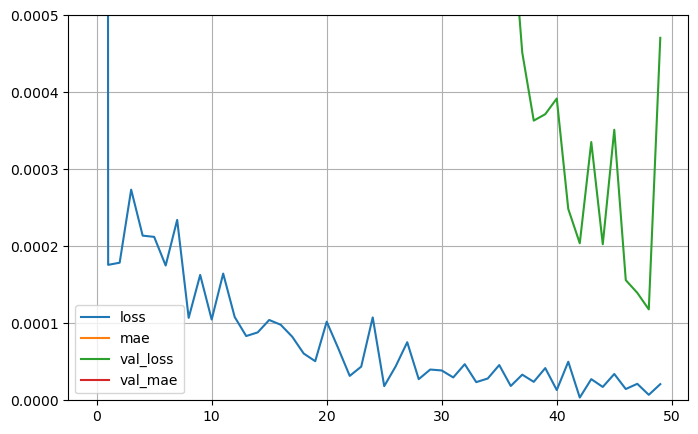

In [42]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 0.0005)
plt.show()

# **Comparación de métricas de los modelos**

In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Supongamos que ya tienes los modelos entrenados y los datos de prueba para cada uno
# model1, model2 son los dos modelos entrenados
# X_test1, y_test1 son el conjunto de prueba del modelo 1
# X_test2, y_test2 son el conjunto de prueba del modelo 2

def compare_models(model1, model2, model1_name, model2_name, X_test1, y_test1, X_test2, y_test2):
    # Hacer predicciones para cada modelo en su propio conjunto de datos
    y_pred_model1 = model1.predict(X_test1)
    y_pred_model2 = model2.predict(X_test2)

    # Calcular métricas para model1 en su dataset
    mse_model1 = mean_squared_error(y_test1, y_pred_model1)
    mae_model1 = mean_absolute_error(y_test1, y_pred_model1)
    r2_model1 = r2_score(y_test1, y_pred_model1)

    # Calcular métricas para model2 en su dataset
    mse_model2 = mean_squared_error(y_test2, y_pred_model2)
    mae_model2 = mean_absolute_error(y_test2, y_pred_model2)
    r2_model2 = r2_score(y_test2, y_pred_model2)

    # Mostrar métricas para cada dataset
    print(f"Métricas del {model1_name} (Dataset 1):")
    print(f"MSE: {mse_model1:.4f}")
    print(f"MAE: {mae_model1:.4f}")
    print(f"R²: {r2_model1:.4f}")

    print(f"\nMétricas del {model2_name} (Dataset 2):")
    print(f"MSE: {mse_model2:.4f}")
    print(f"MAE: {mae_model2:.4f}")
    print(f"R²: {r2_model2:.4f}")

    # Opcional: Normalizar métricas (normalización simple usando el rango de los valores reales)
    range_y_test1 = np.max(y_test1) - np.min(y_test1)
    range_y_test2 = np.max(y_test2) - np.min(y_test2)

    mse_model1_normalized = mse_model1 / range_y_test1
    mse_model2_normalized = mse_model2 / range_y_test2

    print(f"\nMSE Normalizado para {model1_name}: {mse_model1_normalized:.4f}")
    print(f"MSE Normalizado para {model2_name}: {mse_model2_normalized:.4f}")

# Graficar curvas de pérdida durante el entrenamiento si tienes los históricos de entrenamiento
def plot_loss_curve(history1, model_name1, history2, model_name2,  history3, model_name3):
    plt.plot(history1.history['loss'], label=f'Pérdida Entrenamiento {model_name1}')
    plt.plot(history1.history['val_loss'], label=f'Pérdida Validación {model_name1}')
    plt.plot(history2.history['loss'], label=f'Pérdida Entrenamiento {model_name2}')
    plt.plot(history2.history['val_loss'], label=f'Pérdida Validación {model_name2}')
    plt.plot(history3.history['loss'], label=f'Pérdida Entrenamiento {model_name3}')
    plt.plot(history3.history['val_loss'], label=f'Pérdida Validación {model_name3}')
    plt.title('Curvas de Pérdida')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    #plt.gca().set_ylim(0, 0.01)
    plt.legend()
    plt.show()

# Si tienes los históricos de los modelos
# history_model1, history_model2 son los históricos de entrenamiento de cada modelo
# plot_loss_curve(history_model1, 'Model 1')
# plot_loss_curve(history_model2, 'Model 2')

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
261/261 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Métricas del Modelo SS (Dataset 1):
MSE: 0.0000
MAE: 0.0012
R²: 1.0000

Métricas del Modelo LSTM (Dataset 2):
MSE: 0.0000
MAE: 0.0026
R²: 0.9999

MSE Normalizado para Modelo SS: 0.0000
MSE Normalizado para Modelo LSTM: 0.0000


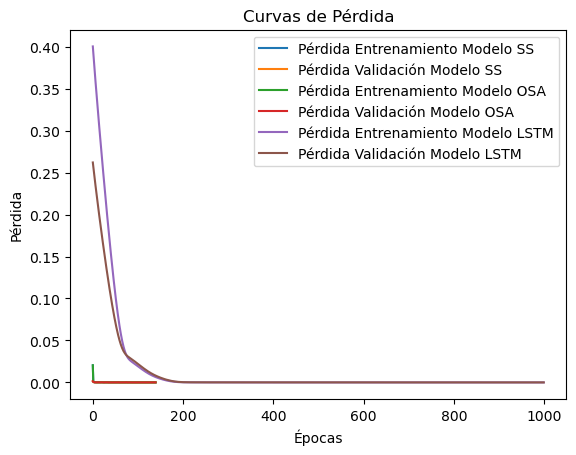

In [44]:
#compare_models(model1, model2, X_test1, y_test1, X_test2, y_test2)
#X_train_LSTM, y_train_LSTM, X_test_LSTM, y_test_LSTM

compare_models(FFNN_OSA_network, LSTM_network,'Modelo SS', 'Modelo LSTM', X_test_OSA, y_test_OSA, X_test_LSTM, y_test_LSTM)
#plot_loss_curve(FFNN_OSA_history , 'Modelo SS')
#plot_loss_curve(LSTM_history, 'Modelo LSTM')
plot_loss_curve(FFNN_OSA_history , 'Modelo SS', FFNN_OSA_history, 'Modelo OSA', LSTM_history, 'Modelo LSTM')

196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 462us/step
261/261 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Métricas del Modelo SS (Dataset 1):
MSE: 0.0000
MAE: 0.0012
R²: 1.0000

Métricas del Modelo LSTM (Dataset 2):
MSE: 0.0000
MAE: 0.0026
R²: 0.9999

MSE Normalizado para Modelo SS: 0.0000
MSE Normalizado para Modelo LSTM: 0.0000


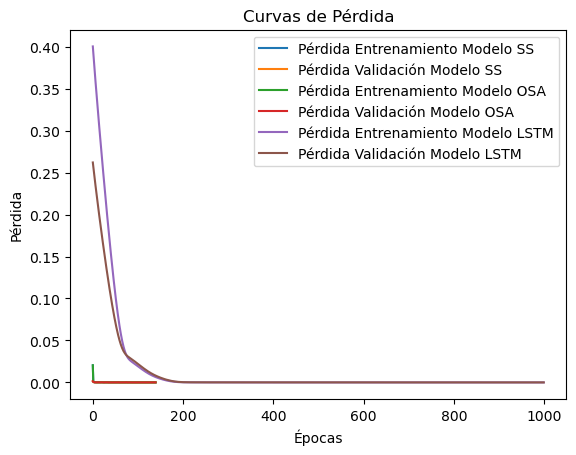

In [45]:
compare_models(FFNN_OSA_network, LSTM_network,'Modelo SS', 'Modelo LSTM', X_test_OSA, y_test_OSA, X_test_LSTM, y_test_LSTM)
#plot_loss_curve(FFNN_OSA_history , 'Modelo SS')
#plot_loss_curve(LSTM_history, 'Modelo LSTM')
plot_loss_curve(FFNN_OSA_history , 'Modelo SS', FFNN_OSA_history, 'Modelo OSA', LSTM_history, 'Modelo LSTM')

# **Verificación con otro conjunto de datos**

In [46]:
#Uso el otro dataset joint

datos_2LRP_ref_joint = pd.read_csv(f'./2lpr_jointmovement_2024_10_15-00_36_00.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)
#datos_2LRP_ref_joint.head()
t_ref = datos_2LRP_ref_joint.iloc[1:-1,1].values

q1_ref = datos_2LRP_ref_joint.iloc[:-2,2].values
q2_ref = datos_2LRP_ref_joint.iloc[:-2,3].values

dq1_ref = datos_2LRP_ref_joint.iloc[:-2,4].values
dq2_ref = datos_2LRP_ref_joint.iloc[:-2,5].values

ddq1_ref = datos_2LRP_ref_joint.iloc[1:-1,6].values
ddq2_ref = datos_2LRP_ref_joint.iloc[1:-1,7].values

t1_ref = datos_2LRP_ref_joint.iloc[1:-1,8].values
t2_ref = datos_2LRP_ref_joint.iloc[1:-1,9].values

next_q1_ref = datos_2LRP_ref_joint.iloc[1:-1,2].values
next_q2_ref = datos_2LRP_ref_joint.iloc[1:-1,3].values

datos_2LRP_ref_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


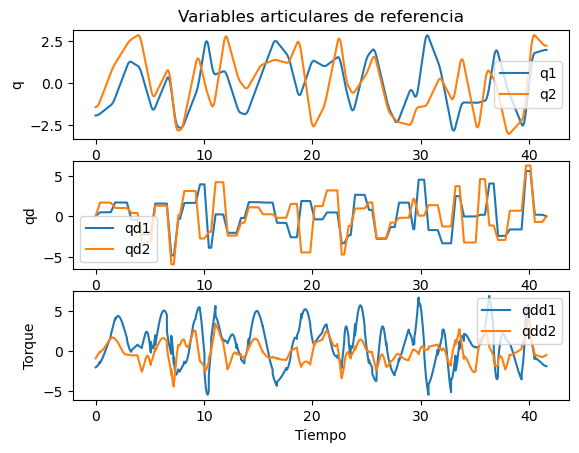

In [47]:
num_links = 2


plt.subplot(3,1,1)
plt.plot(t_ref, q1_ref)
plt.plot(t_ref, q2_ref)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref, dq1_ref)
plt.plot(t_ref, dq2_ref)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref, t1_ref)
plt.plot(t_ref, t2_ref)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('Torque')
plt.show()


In [48]:
inputs_ref = np.vstack((q1_ref,q2_ref,dq1_ref,dq2_ref,t1_ref,t2_ref)).T
outputs_ref = np.vstack((next_q1_ref,next_q2_ref)).T

In [49]:
#Primero con FF NN

X_test_scaled_FF_NN = scaler1_OSA.transform(inputs_ref)
ddq_sim_FF_NN = scaler2_OSA.inverse_transform(FFNN_OSA_network.predict(X_test_scaled_FF_NN))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 470us/step


In [50]:
def create_sequences_with_time(data, time, window_size= w_size):
    sequences = []
    times = []
    
    for i in range(len(data) - window_size + 1):
        sequence = data[i:i + window_size]
        sequences.append(sequence)
        
        # Obtener el tiempo correspondiente al centro de la ventana
        time_center = time[i + window_size // 2]  # Usa el centro de la ventana
        times.append(time_center)
    
    return np.array(sequences), np.array(times)

X_test_scaled_LSTM = scaler1_LSTM.transform(inputs_ref)
X_test_windowed_LSTM, t_ref_LSTM = create_sequences_with_time(X_test_scaled_LSTM, t_ref)
ddq_sim_LSTM = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


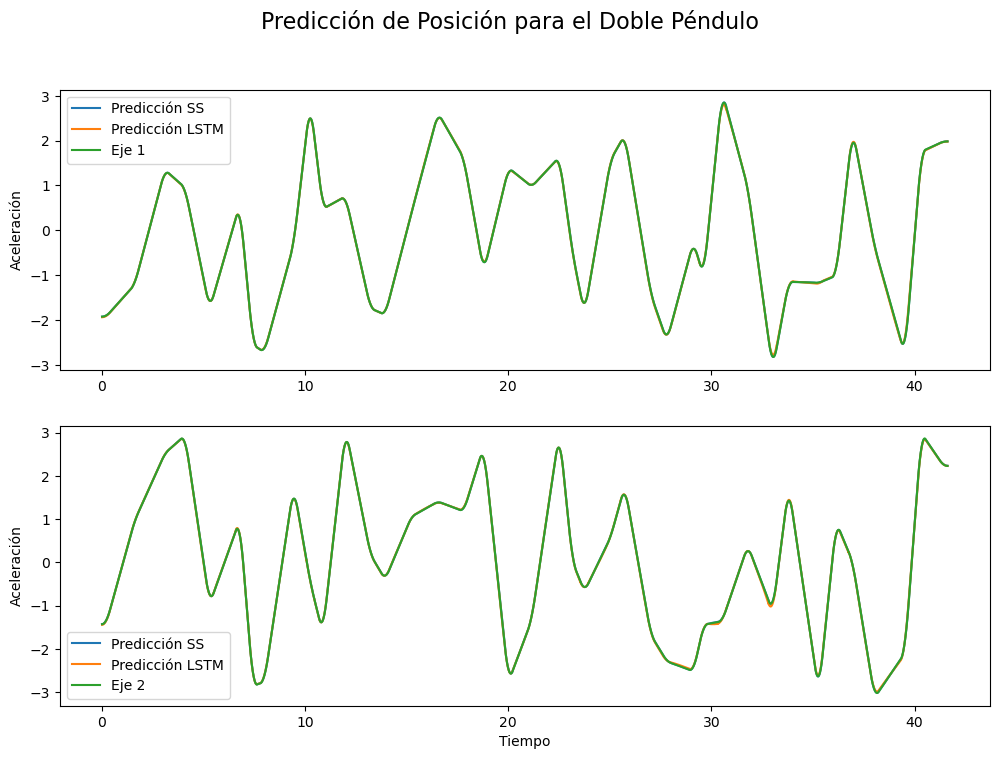

In [51]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Predicción de Posición para el Doble Péndulo", fontsize=16)

# Grafico los resultados
for i in range(num_links):
  plt.subplot(num_links, 1, i+1)
  plt.plot(t_ref,ddq_sim_FF_NN[:,i])
  plt.plot(t_ref_LSTM,ddq_sim_LSTM[:,i])
  plt.plot(t_ref,outputs_ref[:,i])
  plt.ylabel('Aceleración')
  plt.legend(['Predicción SS', 'Predicción LSTM', f'Eje {i+1}'])

plt.xlabel('Tiempo');
plt.show()

# **Comparación de conjunto de Datos, Cartesiano vs Joint**

Para la comparación entre el conjunto de datos Cartesiano vs Joint, voy a crear otras redes neuronales FF y LSTM con las mismas características que las anteriores, entrenándolas exclusivamente con datasets cartesianos, y se compara la estimación de las 4 redes utilizando un nuevo conjunto joint y un nuevo conjunto cartesiano.

In [52]:
#Inputs ---> uk=[qTk-1  d_qTk-1  tauTk]T
time_cart = datos_2LRP_cart.iloc[1:-1,1].values

pos_j1_cart = datos_2LRP_cart.iloc[:-2,2].values
pos_j2_cart = datos_2LRP_cart.iloc[:-2,3].values

vels_j1_cart = datos_2LRP_cart.iloc[:-2,4].values
vels_j2_cart = datos_2LRP_cart.iloc[:-2,5].values

accs_j1_cart = datos_2LRP_cart.iloc[1:-1,6].values
accs_j2_cart = datos_2LRP_cart.iloc[1:-1,7].values

torq_j1_cart = datos_2LRP_cart.iloc[1:-1,8].values
torq_j2_cart = datos_2LRP_cart.iloc[1:-1,9].values

next_pos_j1_cart = datos_2LRP_cart.iloc[1:-1,2].values
next_pos_j2_cart = datos_2LRP_cart.iloc[1:-1,3].values

# Empiezo por el caso FeedForward

In [53]:
inputs_cart = np.vstack((pos_j1_cart, pos_j2_cart, vels_j1_cart, vels_j2_cart, torq_j1_cart, torq_j2_cart)).T
outputs_cart = np.vstack((next_pos_j1_cart,next_pos_j2_cart)).T

In [54]:
#Preparo los datos para la red FF
X_train_FF_cart, X_test_FF_cart, y_train_FF_cart, y_test_FF_cart = train_test_split(inputs_cart, outputs_cart, test_size = 0.15)
X_train_FF_cart, X_val_FF_cart, y_train_FF_cart, y_val_FF_cart = train_test_split(X_train_FF_cart, y_train_FF_cart, test_size=0.15)

In [55]:
#Tengo que hacer preprocesado de los datos para que los calculos no sean tan pesados
scaler1_FF_cart = MinMaxScaler()
X_train_FF_cart = scaler1_FF_cart.fit_transform(X_train_FF_cart)#Primero se llama a la funcion fit para que ajuste los datos
X_test_FF_cart = scaler1_FF_cart.transform(X_test_FF_cart) #Una vez que los datos fueron ajustados se puede llamar a la transformacion directamente
X_val_FF_cart = scaler1_FF_cart.transform(X_val_FF_cart)

#Lo mismo para los outputs
scaler2_FF_cart = MinMaxScaler() #Otra forma de ESCALAR ---> scaler = StandardScaler()
y_train_FF_cart = scaler2_FF_cart.fit_transform(y_train_FF_cart)
y_test_FF_cart = scaler2_FF_cart.transform(y_test_FF_cart)
y_val_FF_cart = scaler2_FF_cart.transform(y_val_FF_cart)

In [56]:
FFNN_network_cart = Sequential()
FFNN_network_cart.add(Dense(input_shape = (inputs.shape[1],), units = 100, activation = 'relu')) # 2x8x4x2
FFNN_network_cart.add(Dense(units=100, activation='relu')) # 2x8x4
FFNN_network_cart.add(Dense(units=100, activation='relu')) # 2x8
FFNN_network_cart.add(Dense(units = 2)) #2
FFNN_network_cart.summary()
FFNN_network_cart.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics = ['mae'])

/Users/melinagabrielacheminet/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 100)            │           700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           202 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,102 (82.43 KB)

 Trainable params: 21,102 (82.43 KB)

 Non-trainable params: 0 (0.00 B)

In [57]:
checkpoint_cb_cart = keras.callbacks.ModelCheckpoint("./DD_NN_Pos/Modelos_NN/FF_NN_cart/FF_NN_nn_Best_Model.keras", save_best_only=True)
early_stopping_cb_cart = keras.callbacks.EarlyStopping(patience=30, restore_best_weights=True)

In [58]:
FFNN_history_cart = FFNN_network_cart.fit(X_train_FF_cart, y_train_FF_cart, batch_size=150, epochs=300, validation_data=(X_val_FF_cart, y_val_FF_cart), callbacks=[checkpoint_cb_cart, early_stopping_cb_cart])

Epoch 1/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0531 - mae: 0.1331 - val_loss: 4.0384e-05 - val_mae: 0.0046
Epoch 2/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7704e-05 - mae: 0.0037 - val_loss: 1.0318e-05 - val_mae: 0.0023
Epoch 3/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8.8562e-06 - mae: 0.0021 - val_loss: 5.5941e-06 - val_mae: 0.0017
Epoch 4/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.9201e-06 - mae: 0.0016 - val_loss: 5.9105e-06 - val_mae: 0.0018
Epoch 5/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8002e-06 - mae: 0.0014 - val_loss: 3.3342e-06 - val_mae: 0.0013
Epoch 6/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9039e-06 - mae: 0.0012 - val_loss: 2.5528e-06 - val_mae: 0.0012
Epoch 7/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.3198e-06 - mae: 0.0011 - val_loss: 1.8047e-06 - val_mae: 9.5132e-04
Epoch 8/300
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8240e-06 - mae: 9.8251e-04 - val_loss: 1.9724e-0

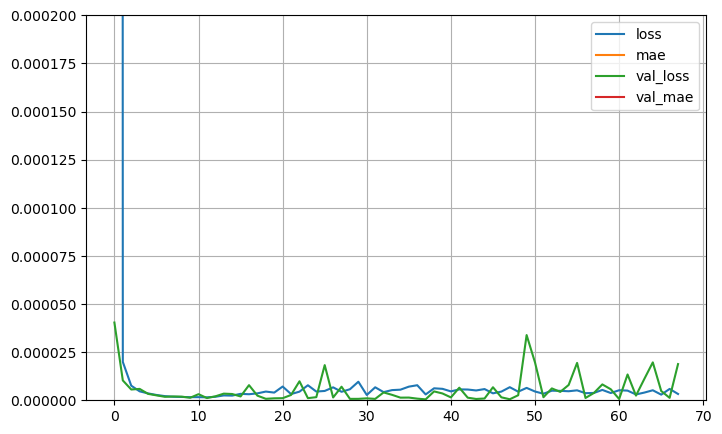

In [59]:
pd.DataFrame(FFNN_history_cart.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 0.0002)
plt.show()

# Caso LSTM

In [60]:
inputs_LSTM_cart = np.vstack((pos_j1_cart, pos_j2_cart, vels_j1_cart, vels_j2_cart, torq_j1_cart, torq_j2_cart)).T
outputs_LSTM_cart = np.vstack((next_pos_j1_cart,next_pos_j2_cart)).T

In [61]:
# Definir el tamaño de la ventana de tiempo para las secuencias
w_size = 6

# Preprocesar (escalar) los inputs y outputs antes de crear las secuencias
scaler1_LSTM_cart = MinMaxScaler()
inputs_LSTM_cart = scaler1_LSTM_cart.fit_transform(inputs_LSTM_cart)

scaler2_LSTM_cart = MinMaxScaler()
outputs_LSTM_cart = scaler2_LSTM_cart.fit_transform(outputs_LSTM_cart)

X_train_LSTM_cart, y_train_LSTM_cart, X_test_LSTM_cart, y_test_LSTM_cart, t_test_LSTM_cart  = create_lstm_sequences(inputs_LSTM_cart, outputs_LSTM_cart, time_cart, window_size=w_size, split=0.8)

In [62]:
LSTM_network_cart = Sequential()
LSTM_network_cart.add(LSTM(units=50, dropout=0, input_shape=(w_size, X_train_LSTM.shape[2]), activation='tanh', return_sequences=True))#, kernel_regularizer=l2(0.005)))
LSTM_network_cart.add(LSTM(50, dropout=0.05, activation='tanh', return_sequences=True)) #, kernel_regularizer=l2(0.0005)
LSTM_network_cart.add(LSTM(50, dropout=0.05, activation='tanh'))
LSTM_network_cart.add(Dense(y_train_LSTM.shape[1]))
# Compile the model
LSTM_network_cart.compile(loss = 'mean_squared_error', optimizer=keras.optimizers.Adam(learning_rate=1e-6), metrics = ['mae'])
LSTM_network_cart.summary()

/Users/melinagabrielacheminet/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 6, 50)          │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,702 (123.84 KB)

 Trainable params: 31,702 (123.84 KB)

 Non-trainable params: 0 (0.00 B)

In [63]:
LSTM_checkpoint_cb_cart = keras.callbacks.ModelCheckpoint("./DD_NN_Pos/Modelos_NN/LSTM_cart/LSTM_nn_Best_Model.keras", save_best_only=True)
#LSTM_checkpoint_cb = keras.callbacks.ModelCheckpoint("./ID_NN/Modelos_NN/LINEAR/LSTM_nn_Best_Model.keras",save_best_only=True)
LSTM_early_stopping_cb_cart = keras.callbacks.EarlyStopping(monitor='val_loss', patience=80, min_delta=1E-10, restore_best_weights=True)

In [64]:
LSTM_history_cart = LSTM_network_cart.fit(X_train_LSTM_cart, y_train_LSTM_cart, epochs=1000, batch_size=150, validation_split=0.3, callbacks=[LSTM_checkpoint_cb_cart, LSTM_early_stopping_cb_cart])

Epoch 1/1000


146/146 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.3201 - mae: 0.5201 - val_loss: 0.3748 - val_mae: 0.5897
Epoch 2/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3163 - mae: 0.5163 - val_loss: 0.3673 - val_mae: 0.5834
Epoch 3/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.3067 - mae: 0.5070 - val_loss: 0.3600 - val_mae: 0.5771
Epoch 4/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2993 - mae: 0.5003 - val_loss: 0.3528 - val_mae: 0.5708
Epoch 5/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2960 - mae: 0.4969 - val_loss: 0.3456 - val_mae: 0.5645
Epoch 6/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2891 - mae: 0.4902 - val_loss: 0.3386 - val_mae: 0.5583
Epoch 7/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2823 - mae: 0.4836 - val_loss: 0.3316 - val_mae: 0.5520
Epoch 8/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.2761 - mae: 0.4770 - val_loss: 0.3246 - val_mae: 0.5457
Epoch 9/1000
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms

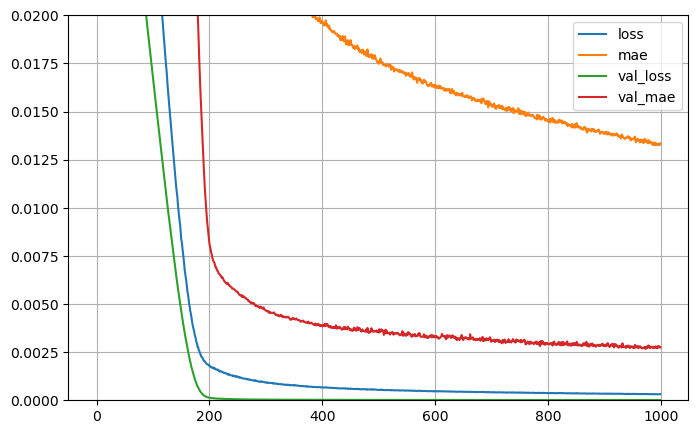

In [65]:
pd.DataFrame(LSTM_history_cart.history).plot(figsize=(8, 5))
plt.grid(True)
#plt.gca().set_xlim(0, 1)
plt.gca().set_ylim(0, 0.02)
plt.show()

# Comparación de estimaciones

**Estimación de Dataset Joint**

In [66]:
#Estimación de Dataset Joint
#Uso el otro dataset joint

datos_2LRP_comp_joint = pd.read_csv(f'./2lpr_jointmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,1].values

q1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,2].values
q2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,3].values

dq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,4].values
dq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[:-2,5].values

ddq1_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,6].values
ddq2_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,7].values

t1_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,8].values
t2_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,9].values

next_q1_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,2].values
next_q2_ref_comp_joint = datos_2LRP_comp_joint.iloc[1:-1,3].values
datos_2LRP_comp_joint.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.926178,-1.430799,0.001258,0.004265,1.257762,4.265447,-2.000074,-0.890958
1,2,0.001,-1.926176,-1.430793,0.002516,0.008531,1.257762,4.265447,-1.999438,-0.888827
2,3,0.002,-1.926173,-1.430782,0.003773,0.012796,1.257762,4.265447,-1.998798,-0.886697
3,4,0.003,-1.926168,-1.430767,0.005031,0.017062,1.257762,4.265447,-1.998153,-0.884568
4,5,0.004,-1.926163,-1.430748,0.006289,0.021327,1.257762,4.265447,-1.997503,-0.882441


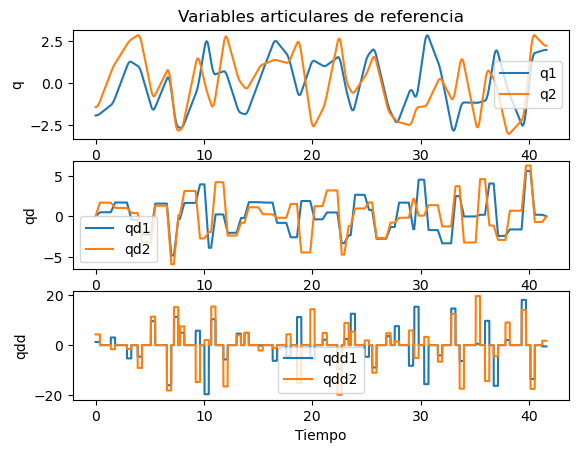

In [67]:
num_links = 2


plt.subplot(3,1,1)
plt.plot(t_ref_comp_joint, q1_ref_comp_joint)
plt.plot(t_ref_comp_joint, q2_ref_comp_joint)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_joint, dq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, dq2_ref_comp_joint)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_joint, ddq1_ref_comp_joint)
plt.plot(t_ref_comp_joint, ddq2_ref_comp_joint)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [68]:
inputs_ref_comp_joint = np.vstack((q1_ref_comp_joint,q2_ref_comp_joint,dq1_ref_comp_joint,dq2_ref_comp_joint,t1_ref_comp_joint,t2_ref_comp_joint)).T
outputs_ref_comp_joint = np.vstack((next_q1_ref_comp_joint,next_q2_ref_comp_joint)).T

In [69]:
#Primero con FF NN entrenada con Cartesianas
X_test_scaled_FF_NN_comp_joint_c = scaler1_FF_cart.transform(inputs_ref_comp_joint)
next_qs_sim_FF_NN_comp_joint_c = scaler2_FF_cart.inverse_transform(FFNN_network_cart.predict(X_test_scaled_FF_NN_comp_joint_c))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 765us/step


In [70]:
#Primero con FF NN entrenada con Joint
X_test_scaled_FF_NN_comp_joint_j = scaler1_OSA.transform(inputs_ref_comp_joint)
next_qs_sim_FF_NN_comp_joint_j = scaler2_OSA.inverse_transform(FFNN_OSA_network.predict(X_test_scaled_FF_NN_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step


In [71]:
#Con LSTM entrenada con Cartesianas
X_test_scaled_LSTM_comp_joint_c = scaler1_LSTM_cart.transform(inputs_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_c, t_ref_LSTM_comp_joint_c = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_c, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_c
next_qs_sim_LSTM_comp_joint_c = scaler2_LSTM_cart.inverse_transform(LSTM_network_cart.predict(X_test_windowed_LSTM_comp_joint_c))
next_qs_sim_LSTM_comp_joint_c

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step


array([[-1.7909179 , -0.93917453],
       [-1.79096   , -0.9392106 ],
       [-1.7910011 , -0.9392433 ],
       ...,
       [ 1.7521977 ,  2.1052353 ],
       [ 1.7522182 ,  2.1052282 ],
       [ 1.7522374 ,  2.105223  ]], dtype=float32)

In [72]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_joint_j = scaler1_LSTM.transform(inputs_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_j, t_ref_LSTM_comp_joint_j = create_sequences_with_time(X_test_scaled_LSTM_comp_joint_j, t_ref_comp_joint)
X_test_windowed_LSTM_comp_joint_j
next_qs_sim_LSTM_comp_joint_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_joint_j))

1301/1301 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


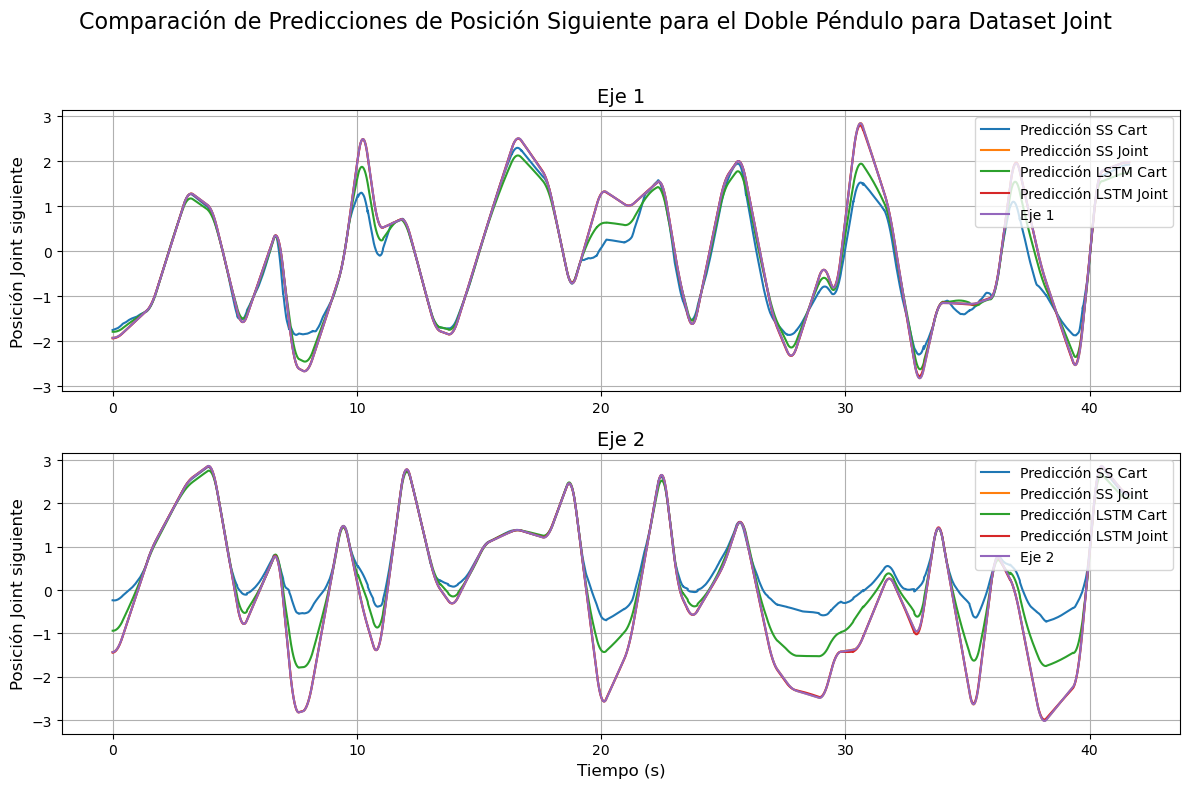

In [73]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Posición Siguiente para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_joint,next_qs_sim_FF_NN_comp_joint_c[:,i], label='Predicción SS Cart')
    plt.plot(t_ref_comp_joint,next_qs_sim_FF_NN_comp_joint_j[:,i], label='Predicción SS Joint')
    plt.plot(t_ref_LSTM_comp_joint_c,next_qs_sim_LSTM_comp_joint_c[:,i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_joint_j,next_qs_sim_LSTM_comp_joint_j[:,i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_joint,outputs_ref_comp_joint[:,i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Posición Joint siguiente', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()

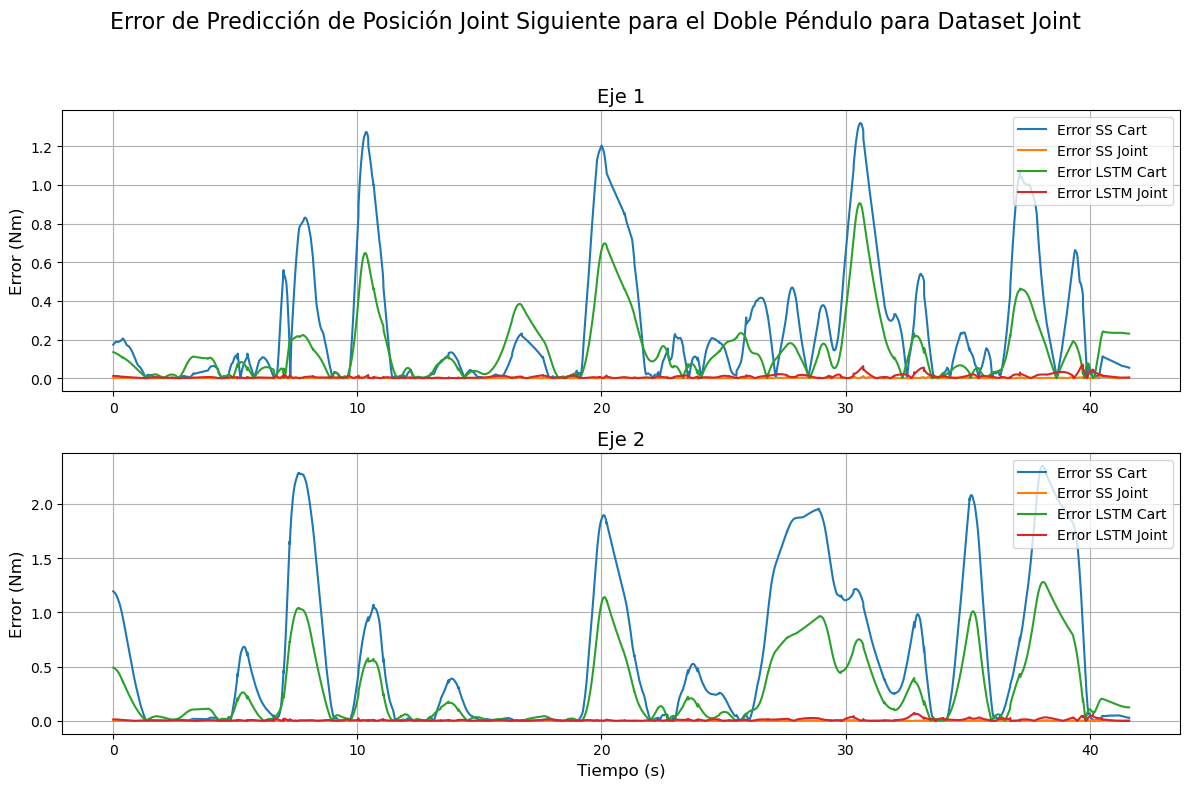

In [74]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Posición Joint Siguiente para el Doble Péndulo para Dataset Joint", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    #error_OSA_Cart_j = (next_qs_sim_FF_NN_comp_joint_c[:, i] - outputs_ref_comp_joint[:, i])
    #error_OSA_Joint_j = (next_qs_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])
    #error_LSTM_Cart_j = (next_qs_sim_LSTM_comp_joint_c[:, i] - outputs_ref_comp_joint[5:, i])
    #error_LSTM_Joint_j = (next_qs_sim_LSTM_comp_joint_j[:, i] - outputs_ref_comp_joint[5:, i])
    error_OSA_Cart_j = np.sqrt((next_qs_sim_FF_NN_comp_joint_c[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_OSA_Joint_j = np.sqrt((next_qs_sim_FF_NN_comp_joint_j[:, i] - outputs_ref_comp_joint[:, i])**2)
    error_LSTM_Cart_j = np.sqrt((next_qs_sim_LSTM_comp_joint_c[:, i] - outputs_ref_comp_joint[5:, i])**2)
    error_LSTM_Joint_j = np.sqrt((next_qs_sim_LSTM_comp_joint_j[:, i] - outputs_ref_comp_joint[5:, i])**2)
    
    # Graficar los errores
    plt.plot(t_ref_comp_joint, error_OSA_Cart_j, label='Error SS Cart')
    plt.plot(t_ref_comp_joint, error_OSA_Joint_j, label='Error SS Joint')
    plt.plot(t_ref_LSTM_comp_joint_c, error_LSTM_Cart_j, label='Error LSTM Cart')
    plt.plot(t_ref_LSTM_comp_joint_j, error_LSTM_Joint_j, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


**Estimación de Dataset Cartesiano**

In [75]:
#Estimación de Dataset Cartesiano

datos_2LRP_comp_cart = pd.read_csv(f'./2lpr_cartesianmovement_2024_12_01-18_04_07.csv',delimiter=',', encoding="utf-8", skipinitialspace=True)

t_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,1].values

q1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,2].values
q2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,3].values

dq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,4].values
dq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[:-2,5].values

ddq1_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,6].values
ddq2_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,7].values

t1_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,8].values
t2_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,9].values

next_q1_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,2].values
next_q2_ref_comp_cart = datos_2LRP_comp_cart.iloc[1:-1,3].values

datos_2LRP_comp_cart.head()

,ID,Time,Theta_1,Theta_2,D_Theta_1,D_Theta_2,DD_Theta_1,DD_Theta_2,Torque_1,Torque_2
0,1,0.000,-1.174887,1.043499,-0.006224,0.011834,-4.149315,7.888932,2.095864,0.976848
1,2,0.001,-1.174893,1.043511,-0.010373,0.019723,-4.149118,7.888525,2.093779,0.980795
2,3,0.002,-1.174903,1.043531,-0.014523,0.027611,-4.148843,7.887955,2.091685,0.984743
3,4,0.003,-1.174918,1.043558,-0.018671,0.035499,-4.148489,7.887223,2.089583,0.988693
4,5,0.004,-1.174936,1.043594,-0.022820,0.043386,-4.148057,7.886328,2.087471,0.992643


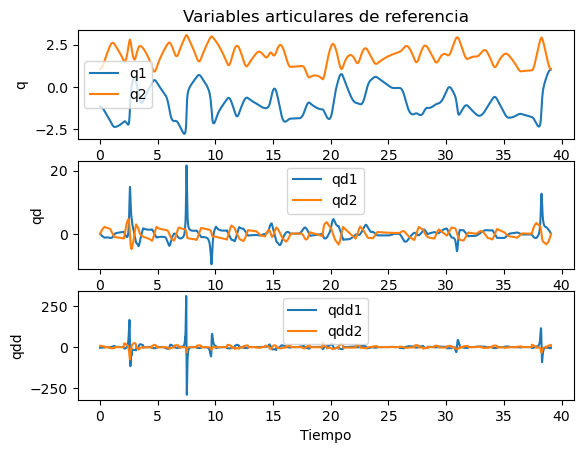

In [76]:
num_links = 2


plt.subplot(3,1,1)
plt.plot(t_ref_comp_cart, q1_ref_comp_cart)
plt.plot(t_ref_comp_cart, q2_ref_comp_cart)
plt.legend(['q1', 'q2']);  plt.ylabel('q')
plt.title('Variables articulares de referencia')
plt.subplot(3,1,2)
plt.plot(t_ref_comp_cart, dq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, dq2_ref_comp_cart)
plt.legend(['qd1', 'qd2']);  plt.ylabel('qd')
plt.subplot(3,1,3)
plt.plot(t_ref_comp_cart, ddq1_ref_comp_cart)
plt.plot(t_ref_comp_cart, ddq2_ref_comp_cart)
plt.legend(['qdd1', 'qdd2']); plt.xlabel('Tiempo'); plt.ylabel('qdd')
plt.show()

In [77]:
inputs_ref_comp_cart = np.vstack((q1_ref_comp_cart,q2_ref_comp_cart,dq1_ref_comp_cart,dq2_ref_comp_cart,t1_ref_comp_cart,t2_ref_comp_cart)).T
outputs_ref_comp_cart = np.vstack((next_q1_ref_comp_cart,next_q2_ref_comp_cart)).T

In [78]:
#Primero con FF NN entrenada con Cart

X_test_scaled_FF_NN_comp_cart_c = scaler1_FF_cart.transform(inputs_ref_comp_cart)
next_qs_sim_FF_NN_comp_cart_c = scaler2_FF_cart.inverse_transform(FFNN_network_cart.predict(X_test_scaled_FF_NN_comp_cart_c))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 544us/step


In [79]:
#Primero con FF NN entrenada con Joint

X_test_scaled_FF_NN_comp_cart_j = scaler1_OSA.transform(inputs_ref_comp_cart)
next_qs_sim_FF_NN_comp_cart_j = scaler2_OSA.inverse_transform(FFNN_OSA_network.predict(X_test_scaled_FF_NN_comp_cart_j))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step


In [80]:
#Con LSTM entrenada con Cart
X_test_scaled_LSTM_comp_cart_c = scaler1_LSTM_cart.transform(inputs_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_c, t_ref_LSTM_comp_cart_c = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_c, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_c
next_qs_sim_LSTM_comp_cart_c = scaler2_LSTM_cart.inverse_transform(LSTM_network_cart.predict(X_test_windowed_LSTM_comp_cart_c))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [81]:
#Con LSTM entrenada con Joint
X_test_scaled_LSTM_comp_cart_j = scaler1_LSTM.transform(inputs_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_j, t_ref_LSTM_comp_cart_j = create_sequences_with_time(X_test_scaled_LSTM_comp_cart_j, t_ref_comp_cart)
X_test_windowed_LSTM_comp_cart_j
next_qs_sim_LSTM_comp_cart_j = scaler2_LSTM.inverse_transform(LSTM_network.predict(X_test_windowed_LSTM_comp_cart_j))

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


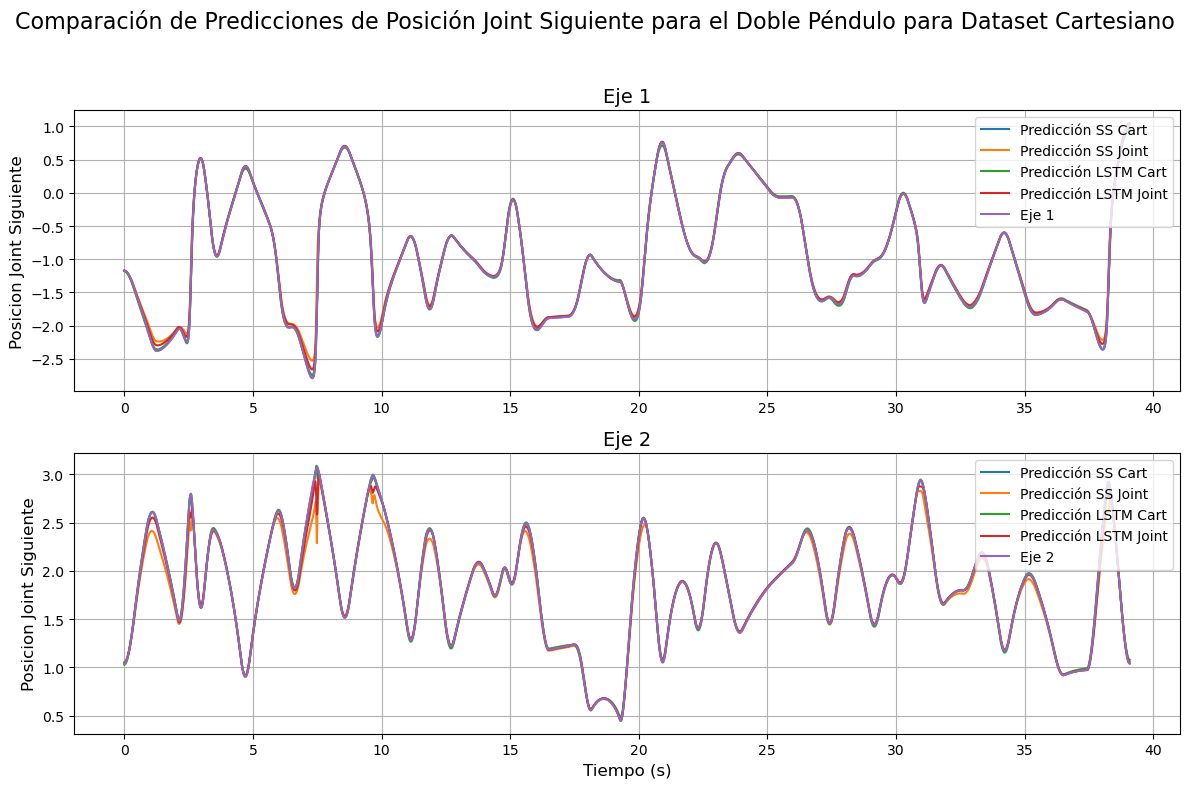

In [82]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Comparación de Predicciones de Posición Joint Siguiente para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los resultados
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Graficar las diferentes predicciones y los valores reales
    plt.plot(t_ref_comp_cart, next_qs_sim_FF_NN_comp_cart_c[:, i], label='Predicción SS Cart')
    plt.plot(t_ref_comp_cart, next_qs_sim_FF_NN_comp_cart_j[:, i], label='Predicción SS Joint')
    plt.plot(t_ref_LSTM_comp_cart_c, next_qs_sim_LSTM_comp_cart_c[:, i], label='Predicción LSTM Cart')
    plt.plot(t_ref_LSTM_comp_cart_j, next_qs_sim_LSTM_comp_cart_j[:, i], label='Predicción LSTM Joint')
    plt.plot(t_ref_comp_cart, outputs_ref_comp_cart[:, i], label=f'Eje {i+1}')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Posicion Joint Siguiente', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


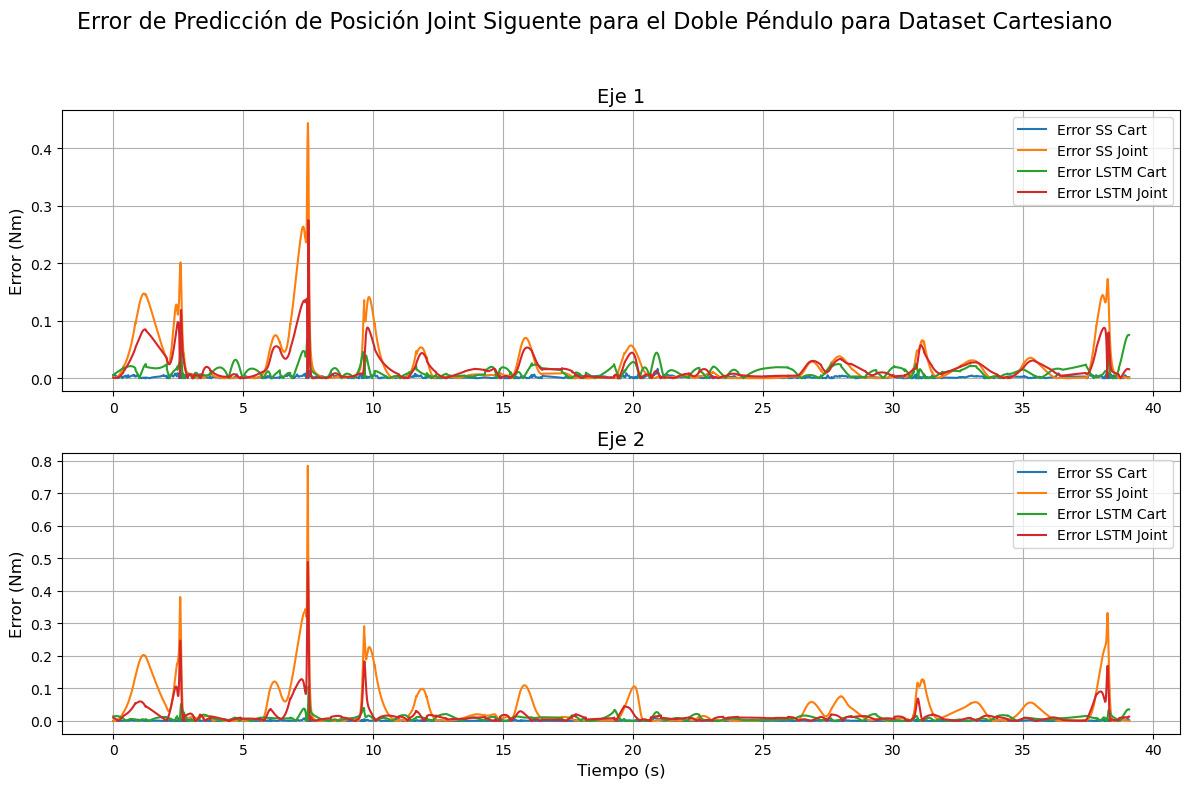

In [83]:
# Ajustar el tamaño de la figura
plt.figure(figsize=(12, 8))  # Cambia el tamaño según tus necesidades

# Agregar un título general
plt.suptitle("Error de Predicción de Posición Joint Siguente para el Doble Péndulo para Dataset Cartesiano", fontsize=16)

# Graficar los errores
for i in range(num_links):
    plt.subplot(num_links, 1, i + 1)
    
    # Calcular errores
    #error_OSA_Cart_c = next_qs_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i]
    #error_OSA_Joint_c = next_qs_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i]
    #error_LSTM_Cart_c = next_qs_sim_LSTM_comp_cart_c[:, i] - outputs_ref_comp_cart[5:, i]
    #error_LSTM_Joint_c = next_qs_sim_LSTM_comp_cart_j[:, i] - outputs_ref_comp_cart[5:, i]

    error_OSA_Cart_c = np.sqrt((next_qs_sim_FF_NN_comp_cart_c[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_OSA_Joint_c = np.sqrt((next_qs_sim_FF_NN_comp_cart_j[:, i] - outputs_ref_comp_cart[:, i])**2)
    error_LSTM_Cart_c = np.sqrt((next_qs_sim_LSTM_comp_cart_c[:, i] - outputs_ref_comp_cart[5:, i])**2)
    error_LSTM_Joint_c = np.sqrt((next_qs_sim_LSTM_comp_cart_j[:, i] - outputs_ref_comp_cart[5:, i])**2)

    # Graficar los errores
    plt.plot(t_ref_comp_cart, error_OSA_Cart_c, label='Error SS Cart')
    plt.plot(t_ref_comp_cart, error_OSA_Joint_c, label='Error SS Joint')
    plt.plot(t_ref_LSTM_comp_cart_c, error_LSTM_Cart_c, label='Error LSTM Cart')
    plt.plot(t_ref_LSTM_comp_cart_j, error_LSTM_Joint_c, label='Error LSTM Joint')
    
    # Ajustar etiquetas y título del subplot
    plt.ylabel('Error (Nm)', fontsize=12)
    plt.title(f'Eje {i+1}', fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.grid(True)  # Añadir una cuadrícula para facilitar la lectura

# Etiqueta para el eje X
plt.xlabel('Tiempo (s)', fontsize=12)

# Ajustar los espacios entre subplots
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Dejar espacio para el título general

# Mostrar el gráfico
plt.show()


# **Reconstrucción de la aceleración**